### Digit Recognizer challenge (Kaggle)

#### The idea of this notebook is to play with different classification algorithms in order to recognize handwritten digits from the go-to computer vision fundamentals dataset MINST

##### Steps that will be followed:
                    - Data cleaning/Formatting. 
                        - Feature scaling, is there a need? There's no need for future scaling, as all features are in the same range (0, 255)
                        - Feature engineering? No need
                        - Is the training set biased? Checked, that's not the case
                        - Data augmentation? In case having more data can be useful (high bias), create more samples from our dataset by rotating or creating images from the original dataset
                    - Split dataset into training, cv and test => Done
                    - Model architecture and optimization
                        - Choose a given model framework (logistic regression, Neuronal Network, Binary Tree)
                        - For neuronal networks, not only consider the number of layers, the neurons per layer, but also the regularization term (we could also include the learning_rate of the adam optimizer, but normally this only affects to the speed of the algorithm, not the output of it!). Higher learning rates should make the algo run faster!
                        - Start with a very simple model (high bias) and make it more complex (high variance one)
                        - Try to plot the decision boundary
                        - Compute the error on the classification as a percentage of the cv size
                        - Computes curves of Error vs parameters
                        - Compute precision and recall and F1 score.
                        - Try to analyze the errors, is there any trend? Meaning, is there any number concretely we are missclassifying more than the others (or for instance, are mumbers that are closed shaped missclassified more than the rest?). This will help us understand what the algo is lacking.
                        - Compute also main metrics as precision and recall for the algorithm
                        - Determine of the algo suffers from high bias or high variance or both 
                

The challenge specifies that the metric to be ranked will be the categorization accuracy, or in other words, the proportion of images that are correctly classified divided by the total number of predictions (TP/(TP+FN))

In [18]:
# Imports
import pandas as pd
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from keras import Sequential,Input
#from keras.losses import MeanSquaredError, BinaryCrossentropy, SparseCategoricalCrossentropy
#from keras.activations import sigmoid, relu, linear
#from keras import layers,Sequential
#from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#from keras.optimizers import Adam
import utils_digit_recognition as udr

In [20]:
# Import the data
path = "~/Code/Kaggle/Digit_Recognizer/train.csv"
train_data = pd.read_csv(path)
train_data.head(7)

# Check if there are any duplicates
print(f"number of duplicates = {sum(train_data.duplicated())}")

# As it can be read in the description of the project,
# the first column contains the digit, a.k.a label, 
# and the other 784 columns represent pixel values from
# 0 to 255. Every row corresponds to a single
# image, which is unfolded from a 28x28 matrix.

number of duplicates = 0


##### The very first part of the project will  be devoted to analyze our data. First of all, we'll split our data into train and cv and we will check whether our dataset is balanced (each category has the same relative frequency) and we'll plot some images to have a grasp on how the handwritten numbers are

In [21]:
# Get relative frequencies of labels
n,m = train_data.shape
categories = train_data['label'].nunique()
print(f"our train dataset contains {n} images")
print(f"where each image contains {m} pixels")
print(f"and each image can be classified as one of {categories} different handwritten numbers")
freq = train_data.groupby("label").size()/n
freq.name='relative frequencies'
freq
# As it can be observed, the relative frequencies of labels in the dataset
# is pretty much the same, which ensures we have a non-skewed training set

our train dataset contains 42000 images
where each image contains 785 pixels
and each image can be classified as one of 10 different handwritten numbers


label
0    0.098381
1    0.111524
2    0.099452
3    0.103595
4    0.096952
5    0.090357
6    0.098500
7    0.104786
8    0.096738
9    0.099714
Name: relative frequencies, dtype: float64

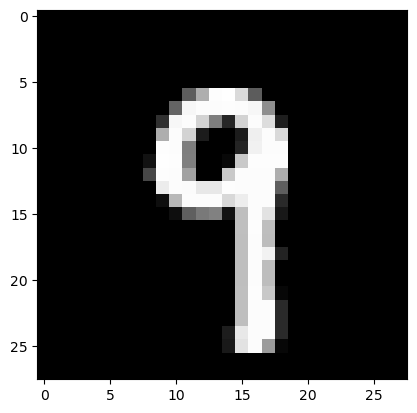

In [23]:
# We'll divide the data into a 2/3 - 1/3 split, 2/3 of it will be used 
# to compute our model parameters and 1/3 of it to fine-tune 
# the hyperparameters we're using a fixed random_state=42 to make 
# the results reproductible across multiple calls 
# (maybe good to try to remove it once we have model selected)
x_train, x_cv, y_train, y_cv = train_test_split(train_data.iloc[:,1:], train_data['label'], train_size=0.66, random_state=42)
plt.imshow(np.array(x_train.iloc[0,:]).reshape(28,28),cmap='gray', vmin=0, vmax=255)

# To-do: In case we see our algorithm experiences high bias (both J_test and J_cv are high), we can try to
# augment the input data by rotating the numbers. Mathematically, those transformations are 
# a linear transformation of what we alredy have, so co-dependence issues could arise from
# such transformation. In case we see that the algo does not improve after doing that,
# we can add some white noise to the image to make it non-linearly dependent

In [24]:
# Our first shot for a classifier will be a Dense Neuronal Network
# where we'll make use of the SparseCategoricalCrossEntropy
# loss function (Softmax function, suited for a multilabel classification problem)
# as an optimizer, we'll use Adam optimizer, just a version
# of gradient descent in which the learning rate, alpha,
# changes differently for different parameters

# For the neurons, we'll make use of achitectures with reducing
# number of nodes per layer and we'll try with three different
# values of lambda (0.1 and 10)
models = {'A_50_20_.0':{'nn':[50,20],
                    'lambda':0.0},
          'A_30_20_.0':{'nn':[30,20],
                    'lambda':0.0},
          'A_50_30_20_.0':{'nn':[50,30,20],
                        'lambda':0.0},
          'A_40_20_15_.0':{'nn':[40,20,15],
                        'lambda':0.0},
          'A_50_20_.1':{'nn':[50,20],
                    'lambda':0.1},
          'A_30_20_.1':{'nn':[30,20],
                    'lambda':0.1},
          'A_50_30_20_.1':{'nn':[50,30,20],
                        'lambda':0.1},
          'A_40_20_15_.1':{'nn':[40,20,15],
                        'lambda':0.1},
          'A_50_20_10.':{'nn':[50,20],
                    'lambda':10},
          'A_30_20_10.':{'nn':[30,20],
                    'lambda':10}, 
          'A_50_30_20_10.':{'nn':[50,30,20],
                        'lambda':10},
          'A_40_20_15_10.':{'nn':[40,20,15],
                        'lambda':10}}

#models = {'try1':{'nn':[20,15],
#                  'lambda':0.1}}
i=0
results = {}
for model_key,model_params in models.items():
    results[model_key] = udr.build_model_and_train(model_params,x_train,y_train,x_cv,y_cv,categories)
    i+=1
    print(f"Progress...{i/len(models)}")

Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 9.5196
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 1.0154
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.6890
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - loss: 0.5201
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.3773
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.3050
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.2727
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.2467
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.2290
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - loss: 0.2052
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.1810
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 0.1818
Epoch 13/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - loss: 0.1629
Epoch 14/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 0.1502
Epoch 15/25
867/867 ━━━━━━━━━

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,442 (474.39 KB)

 Trainable params: 40,480 (158.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,962 (316.26 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
Progress...0.08333333333333333
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 9.3947
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.7920
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.5427
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - loss: 0.4361
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - loss: 0.3748
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - loss: 0.3340
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.2866
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 0.2643
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.2532
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.2317
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.2240
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.2166
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,142 (285.71 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,762 (190.48 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
Progress...0.16666666666666666
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - loss: 4.2478
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - loss: 0.6493
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - loss: 0.4957
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.4129
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.3133
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - loss: 0.2685
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.2411
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 0.2106
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.1918
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - loss: 0.1656
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.1680
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - loss: 0.1464
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,832 (487.63 KB)

 Trainable params: 41,610 (162.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,222 (325.09 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
Progress...0.25
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 3.6160
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 1.1373
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.8583
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - loss: 0.6534
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.5209
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.4282
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.3370
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.2940
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - loss: 0.2295
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.2144
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.1920
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.1736
Epoch 13/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 80

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,087 (383.16 KB)

 Trainable params: 32,695 (127.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,392 (255.44 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Progress...0.3333333333333333
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - loss: 13.6874
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - loss: 3.3857
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - loss: 1.4663
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - loss: 0.8022
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.5638
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.4883
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.4701
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - loss: 0.4562
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - loss: 0.4558
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 0.4404
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 0.4520
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.4409
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,442 (474.39 KB)

 Trainable params: 40,480 (158.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,962 (316.26 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
Progress...0.4166666666666667
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - loss: 11.2585
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: 2.3932
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.9237
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.5616
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 0.4694
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.4534
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.4518
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.4439
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.4479
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.4458
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 0.4472
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.4450
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,142 (285.71 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,762 (190.48 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Progress...0.5
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 13.6323
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - loss: 2.4720
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - loss: 0.8730
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 0.5665
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - loss: 0.5180
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.5112
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.5123
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - loss: 0.5091
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - loss: 0.5073
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.4952
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - loss: 0.4972
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 0.4912
Epoch 13/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 85

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,832 (487.63 KB)

 Trainable params: 41,610 (162.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,222 (325.09 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Progress...0.5833333333333334
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - loss: 11.1850
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - loss: 1.9324
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.8061
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.5837
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.5294
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - loss: 0.5180
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.5171
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.5113
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 0.5041
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - loss: 0.4987
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 0.4989
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.4878
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,087 (383.16 KB)

 Trainable params: 32,695 (127.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,392 (255.44 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Progress...0.6666666666666666
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - loss: 249.8367
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 1.4451
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - loss: 1.3601
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 1.2997
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 1.2423
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 1.2402
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 1.2082
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 1.1797
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 1.1496
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 1.1451
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - loss: 1.1511
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 1.1043
Epoch 13/25
867/867 ━━━━━━━━━━

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,442 (474.39 KB)

 Trainable params: 40,480 (158.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,962 (316.26 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
Progress...0.75
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 185.6715
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 1.4412
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 1.3382
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 1.2559
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 1.2019
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 1.1759
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 1.1701
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - loss: 1.1309
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 1.1151
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - loss: 1.1113
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 1.1128
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 1.1007
Epoch 13/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,142 (285.71 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,762 (190.48 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
Progress...0.8333333333333334
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 328.3564
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 2.3036
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - loss: 2.3017
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - loss: 2.3017
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 2.3017
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - loss: 2.3017
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 2.3017
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 2.3018
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - loss: 2.3018
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - loss: 2.3018
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - loss: 2.3019
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 2.3019
Epoch 13/25
867/867 ━━━━━━━━━━

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,832 (487.63 KB)

 Trainable params: 41,610 (162.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,222 (325.09 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
Progress...0.9166666666666666
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 258.8440
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 2.3079
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 2.3016
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - loss: 2.3016
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 2.3016
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 2.3016
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 2.3017
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 2.3017
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 2.3017
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 2.3017
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 2.3017
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - loss: 2.3018
Epoch 13/25
867/867 ━━━━━━━━━━

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,087 (383.16 KB)

 Trainable params: 32,695 (127.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,392 (255.44 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Progress...1.0


Analyze the relationship between the Adam optimizer cost and the number of iterations. As it can be seen, the cost function (error) converges for all configurations, which is a sign that all parameters have been fitted to find a local minima of the cost function. Little to no value can be grasp from increasing epoch then (which would increase computation time quite substantially)

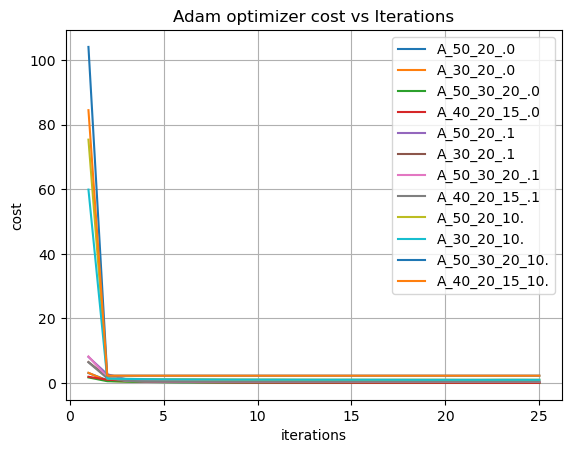

In [25]:
error_logs = [tuple([list(results[model][-1].history.values())[0],model]) for model in results] 
udr.plot_adam_cost(error_logs)

The next thing we have to determine is whether our models suffer from bias, variance, or both. In order to do so, we'll take a look at how the relationship between them changes across the parameter settings


In [26]:
model_train_cv_cost = [[model,round(stats[1],5),round(stats[2],5)] for model,stats in results.items()]
model_train_cv_cost = pd.DataFrame(model_train_cv_cost,columns=['model_params','J_test', 'J_cv'])
model_train_cv_cost

,model_params,J_test,J_cv
0,A_50_20_.0,0.02551,0.05231
1,A_30_20_.0,0.03589,0.06436
2,A_50_30_20_.0,0.01869,0.04692
3,A_40_20_15_.0,0.02168,0.05392
4,A_50_20_.1,0.08557,0.09118
5,A_30_20_.1,0.06429,0.07206
6,A_50_30_20_.1,0.10314,0.11246
7,A_40_20_15_.1,0.08416,0.09202
8,A_50_20_10.,0.27222,0.27010
9,A_30_20_10.,0.21371,0.21590


In [36]:
best_config = model_train_cv_cost.loc[model_train_cv_cost['J_cv']==min(model_train_cv_cost['J_cv']),:]
best_config

,model_params,J_test,J_cv
2,A_50_30_20_.0,0.01869,0.04692


What is the human level performance we could expect from such a task? 99.99% maybe? If we compare that with the results obtained so far, we see that our best configuration delivers a 4.7% error in the cross validation set, with an error of 1.9% in the train dataset. Wrt our baseline level performance, which is at 0.001%, we consider this error still unacceptable, and we diagnose the algorithm to have **high bias** (J_test is >> baseline). Note that our J_cv >> J_test, so we could consider it to have **high variance** as well.  In order to improve this, we'll consider:
- Add more layers
- Add more neurons per layer
- Since we will increase the complexity of the algorithm, we may have to increase the value of the regularization algorithm, otherwise we may incurr overfitting.

After doing that, the next thing we can do is **Error analysis** => Analyze distributions of errors to see if there's a given category that is being misclassified more than others